In [1]:
## driftmlp is the package implementing this methodology
import driftmlp
## h3 to convert locations to their h3 indices.
## Where possible we use driftmlp.helpers.return_h3_inds()
import h3.api.basic_int as h3

## core python packages
import os
import numpy as np #
import pandas as pd
import pickle


## Matplotlib for plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from matplotlib import rc 
## Cartopy for map projections
import cartopy.crs as ccrs
import cartopy.crs as ccrs

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns





## geopandas for aid storing Polygons and plotting
import geopandas as gpd
from shapely.geometry import Polygon, Point

from scipy.stats import pearsonr, spearmanr 

import string
alphabet = string.ascii_lowercase

def get_non_zeros(arr):
    mask = arr!=0
    return arr[mask].flatten()


def get_non_zeros(arr):
    mask = arr!=0
    return arr[mask].flatten()


def nested_list_of_paths_to_tt(nested_list):
    return [[path.travel_time for path in list_of_paths] for list_of_paths in nested_list]

driftfile = os.environ['DRIFTFILE'] 
### Generated by MakeDefNetworks
networks = pickle.load(open('default_networks.p', 'rb'))

### Only use drogued drifters
network = networks[True]
postfix = 'drg'
del networks


### Our example locations are in locations.txt
stations = np.loadtxt("locations.txt", delimiter=',')
stations = pd.DataFrame(stations, index=range(1, 8))
stations.columns = ['Longitude', 'Latitude']
from driftmlp import DefaultSystem
stations['h3'] = DefaultSystem.return_inds([i[['Longitude', 'Latitude']].to_list() for _,i in stations.iterrows()])

# Sensitivity to Hyper Parameter

- Lagrangian cut off point

# Lagranigan cut off point

To assess how accurate the Lagrangian cut off time is we will investigate how the travel times changes as we use a range of different values.

The measurement will be the average difference between the 5 day travel time matrix and the x day travel time matrix.
we will:

1. Create the network for each value of $\mathcal{T}_L$.

2. Obtain a travel time matrix for each trial value.

3. Plot an example, comparing the off-diagonal elements of the travel time matrix at $\mathcal{T}_L=5$ and a $\mathcal{T}_L$ to see if there's a linear trend.

4. Look at the spearman correlation between the travel time matrix at $\mathcal{T}_L=5$ and a $\mathcal{T}_L$.

In [2]:
stories = network['stories']
observations_per_day = network['observations_per_day']
trial_cut_offs = list(np.arange(0.5,14.0,0.5))
def new_network(stories, day_cut_off, observations_per_day):
    return driftmlp.form_network.make_transition(stories, day_cut_off, observations_per_day)
print(trial_cut_offs)

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5]


In [3]:
networks = [new_network(stories, trial_cut_off, observations_per_day) for trial_cut_off in trial_cut_offs]

In [4]:
locs = stations['h3'].tolist()
l = trial_cut_offs.index(5)
five_network = networks.pop(l)
trial_cut_offs.pop(l)
all_paths = [driftmlp.shortest_path.AllPairwisePaths(network, locs) for network in networks]
paths_used = driftmlp.shortest_path.AllPairwisePaths(five_network, locs)

In [5]:
def nested_list_of_paths_to_tt(nested_list):
    return [[path.travel_time for path in list_of_paths] for list_of_paths in nested_list]
all_tts = np.array([nested_list_of_paths_to_tt(nested_list) for nested_list in all_paths])
### Get the original 0 rotation matrix
our_tts = np.array(nested_list_of_paths_to_tt(paths_used))
N = our_tts.shape[0]
num_nonzero = (N*(N-1)/2)

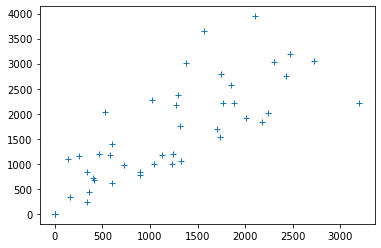

In [6]:
plt.plot(all_tts[2,:,:].flatten(), our_tts.flatten(), '+')

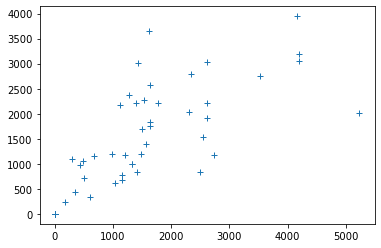

In [7]:
plt.plot(all_tts[-1,:,:].flatten(), our_tts.flatten(), '+')

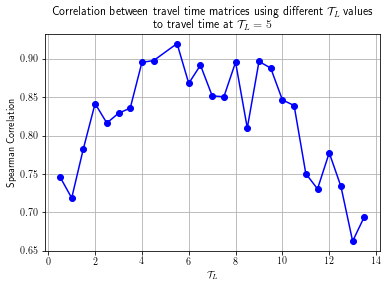

In [8]:
rc('text', usetex=True)

non_zero_tts = [get_non_zeros(all_tts[i, :,:]) for i in range(all_tts.shape[0])]
mark = get_non_zeros(our_tts)
fig = plt.figure()
corrs = [spearmanr(mark, non_zero_tt)[0] for non_zero_tt in non_zero_tts]
plt.plot(trial_cut_offs, corrs ,'bo-',label='spearman')
#corrs = [pearsonr(mark, non_zero_tt)[0] for non_zero_tt in non_zero_tts]
#plt.plot(trial_cut_offs, corrs ,'ro-',label='pearson', )
ax = fig.gca()
ax.grid()
ax.set_xlabel('$\mathcal{T}_L$')
ax.set_ylabel('Spearman Correlation ')
ax.set_title('Correlation between travel time matrices using different $\mathcal{T}_L$ values \n to travel time at $\mathcal{T}_L=5$')

fig.savefig('Images/cut_off_time.png')
fig.savefig('Images/cut_off_time.pdf')

# Rotations

For comparsion purposes, we get the correlation between the travel times computed at $\mathcal{T}_l=5$ with no rotation and $\mathcal{T}_l=5$ for each of the 100 rotations.

In [9]:
## Number of rotations
from driftmlp.drifter_indexing.discrete_system import h3_default

nets = pickle.load(open('rotations_100_3_10.p', 'rb'))
origins = [stations.iloc[i].loc[['Longitude', 'Latitude']].to_list() for i in range(stations.shape[0])]
print(origins)
plot_n=len(nets)

def nested_list_of_paths_to_tt(nested_list):
    return [[path.travel_time for path in list_of_paths] for list_of_paths in nested_list]
from shapely.geometry import Point
def get_all_paths(network, res=3):
    sys = h3_default(res=3, rot=network['rotation'])
    indices = sys.return_inds(origins)
    paths = driftmlp.shortest_path.AllPairwisePaths(network, indices)
    return paths
#%timeit path_and_df(nets[5],network['gpd'])
res = []
for i in range(plot_n):
    res.append(get_all_paths(nets[i]))
    
tt_mats = list(map(nested_list_of_paths_to_tt,res))
del(nets)

[[9.0, -25.5], [-25.0, -5.0], [-45.0, -40.0], [-69.0, 39.0], [-42.5, 41.5], [-42.0, 27.5], [-93.2, 24.8]]


In [10]:
rot_matrices = np.array(tt_mats)
non_zero_tts = [get_non_zeros(rot_matrices[i, :,:]) for i in range(rot_matrices.shape[0])]
corrs = [spearmanr(mark, non_zero_tt)[0] for non_zero_tt in non_zero_tts]

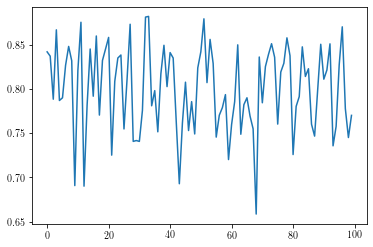

In [11]:
plt.figure()
plt.plot(list(range(100)), corrs)

The mean is below, which is usally lower than the correlation across the $\mathcal{T}_L$, implying that the value of $\mathcal{T}_L$ is not overly sensitive.

In [12]:
np.mean(corrs)

0.8003062960862166

In [13]:
rot_mean = rot_matrices.mean(axis=0)
non_zero_rot_mean = get_non_zeros(rot_mean)
corrs_to_mean = [spearmanr(non_zero_rot_mean, non_zero_tt)[0] for non_zero_tt in non_zero_tts]
print(np.mean(corrs_to_mean))

0.8975447694676284


In [14]:
rot_median = np.median(rot_matrices, axis=0)

In [15]:
pickle.dump([rot_mean, rot_median], open("100_rot.p", "wb"))

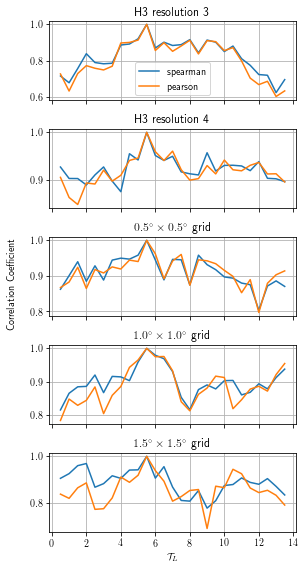

In [82]:
travel_times_gs = pickle.load(open("Sensitivity_gridtime.p", "rb"))
fig, axs = plt.subplots(5,1,sharex=True, figsize=(4,8))
plot_names = ["H3 resolution 3", "H3 resolution 4"] + [f'${x}^\circ \\times {x}^\circ$ grid'for x in np.arange(0.5,1.6,0.5)]
def get_travel_times(data):
    return np.array([[path.travel_time  for path in list_of_paths] for list_of_paths in data])
mark= non_zero_rot_mean
for ax, data, plot_name in zip(axs, travel_times_gs, plot_names):
    non_zeros = [get_non_zeros(get_travel_times(data[key])) for key in data.keys()]
    mark = non_zeros[10]
    corrs = [spearmanr(r, mark)[0] for r in non_zeros]
    ax.plot(list(data.keys()), corrs, label='spearman')
    ax.set_title(plot_name)
    corrs = [pearsonr(r, mark)[0] for r in non_zeros]
    ax.plot(list(data.keys()), corrs, label='pearson')
    ax.set_title(plot_name)
    ax.grid()
axs[0].legend()
axs[4].set_xlabel("$\mathcal{T}_L$")
fig.text(-0.04, 0.5, 'Correlation Coefficient', va='center', rotation='vertical')
fig.tight_layout()
fig.savefig("Images/Resolution_sens_corr.pdf", bbox_inches='tight')

In [74]:
data[list(data.keys())[0]][0][0].travel_time

0

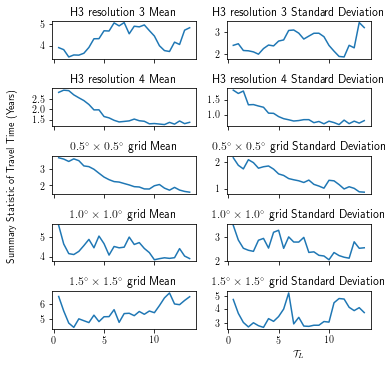

In [81]:
fig, axs = plt.subplots(5,2,sharex=True, figsize=(5,5))
plot_names = ["H3 resolution 3", "H3 resolution 4"] + [f'${x}^\circ \\times {x}^\circ$ grid'for x in np.arange(0.5,1.6,0.5)]
def get_travel_times(path_data):
    return np.array([[path.travel_time  for path in list_of_paths] for list_of_paths in path_data])
mark= non_zero_rot_mean

for row, data, plot_name in zip(range(5), travel_times_gs, plot_names):
    non_zeros = [get_non_zeros(get_travel_times(data[key])) for key in data.keys()]
    means = [np.mean(non_zero)/365 for non_zero in non_zeros]
    variances = [np.std(non_zero,ddof=1)/365 for non_zero in non_zeros]
    keys = list(data.keys())
    axs[row,0].set_title(plot_name+' Mean')
    axs[row,1].set_title(plot_name+' Standard Deviation')
    axs[row, 0].plot(keys, means)
    axs[row, 1].plot(keys, variances)
    #axs[row,2].plot(keys, [get_travel_times(data[key])[1,3] for key in data.keys()], label='1->4')
    #axs[row,2].plot(keys, [get_travel_times(data[key])[0,2] for key in data.keys()], label='3->1')
    #axs[row,2].axvline(5)
#axs[0,0].legend()
fig.tight_layout()
axs[4,1].set_xlabel("$\mathcal{T}_L$")
fig.text(-0.04, 0.5, 'Summary Statistic of Travel Time (Years)', va='center', rotation='vertical')
fig.savefig("Images/sensitivity.pdf", bbox_inches='tight')

In [79]:
t5data = []
for data in travel_times_gs:
    t5data.append(get_non_zeros(get_travel_times(data[5.0])))
m=len(t5data)
arr_res=np.array([[spearmanr(t5data[i], t5data[j])[0] for j in range(m)] for i in range(m)])

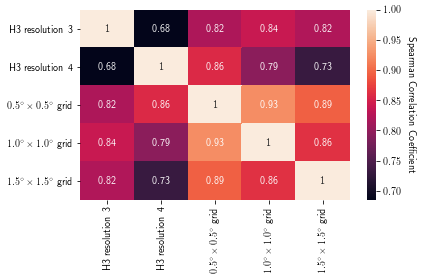

In [80]:
fig=plt.figure(figsize=(6,4))
ax.set_title("Correlation values at $\mathcal{T}_L=5$")
ax = sns.heatmap(arr_res[:,:],xticklabels=plot_names,yticklabels=plot_names, annot=True)
cbar = ax.collections[0].colorbar
cbar.set_label('Spearman Correlation Coefficient', rotation=270, labelpad=15)
fig.tight_layout()
fig.savefig("Images/corr_heatmap.pdf")

In [78]:
#sns.pairplot(data, xticklabels=plot_names, yticklabels=plot_names)